<a href="https://colab.research.google.com/github/sanjanabayya30/Proj/blob/main/FJSSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 0, Makespan: 565, Epsilon: 1.000
Episode 100, Makespan: 584, Epsilon: 0.606
Episode 200, Makespan: 589, Epsilon: 0.367
Episode 300, Makespan: 574, Epsilon: 0.222
Episode 400, Makespan: 572, Epsilon: 0.135
Episode 500, Makespan: 552, Epsilon: 0.082
Episode 600, Makespan: 595, Epsilon: 0.049
Episode 700, Makespan: 577, Epsilon: 0.030
Episode 800, Makespan: 566, Epsilon: 0.018
Episode 900, Makespan: 587, Epsilon: 0.011
Episode 1000, Makespan: 595, Epsilon: 0.010
Episode 1100, Makespan: 589, Epsilon: 0.010
Episode 1200, Makespan: 572, Epsilon: 0.010
Episode 1300, Makespan: 588, Epsilon: 0.010
Episode 1400, Makespan: 580, Epsilon: 0.010
Episode 1500, Makespan: 626, Epsilon: 0.010
Episode 1600, Makespan: 581, Epsilon: 0.010
Episode 1700, Makespan: 560, Epsilon: 0.010
Episode 1800, Makespan: 587, Epsilon: 0.010
Episode 1900, Makespan: 565, Epsilon: 0.010
Episode 2000, Makespan: 564, Epsilon: 0.010
Episode 2100, Makespan: 558, Epsilon: 0.010
Episode 2200, Makespan: 596, Epsilon: 0.010


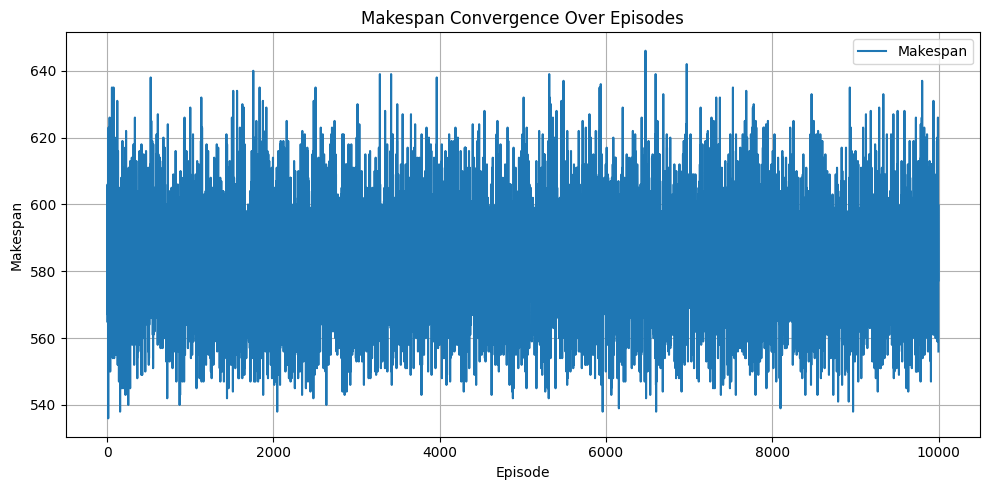

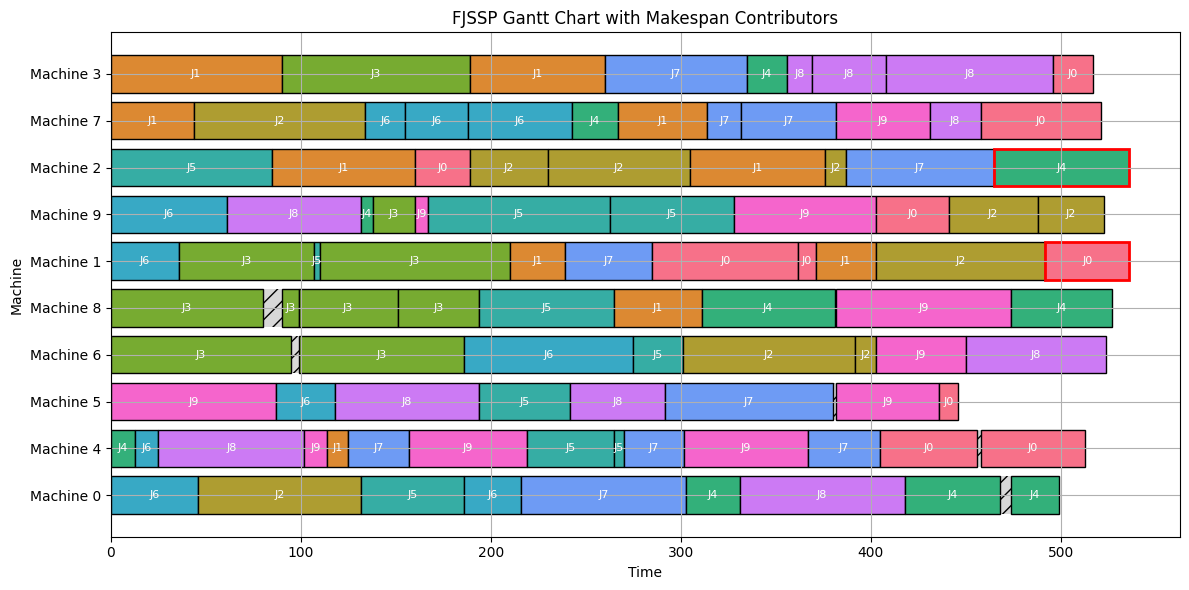

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
import zipfile
from scipy.special import softmax

# Configuration
CONFIG = {
    "seed": 42,
    "alpha": 0.1,
    "gamma": 0.95,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "final_epsilon": 0.01,
    "T": 1.0,
    "T_decay": 0.995,
    "episodes": 10000
}

# Initialize
random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
Q = defaultdict(lambda: 0.0)

def load_dataset(zip_path, file_name):
    """Load and validate dataset from ZIP file."""
    with zipfile.ZipFile(zip_path) as zf:
        with zf.open(file_name) as file:
            df = pd.read_csv(file)
    required_columns = ["Job ID", "Operation", "Machine", "Processing Time"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Dataset missing required columns: {required_columns}")
    df["Machine"] = df["Machine"].apply(lambda x: int(x[1:]) if isinstance(x, str) and x.startswith('M') else int(x))
    return df

def initialize_flexible_operations(df, num_machines, all_machines):
    """Generate fixed alternative machines for each job-operation pair."""
    flexible_ops = defaultdict(lambda: defaultdict(list))
    machine_candidates = {}
    for _, row in df.iterrows():
        job, op, orig_m, pt = int(row["Job ID"]), int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])
        key = (job, op)
        if key not in machine_candidates:
            sampled = random.sample([m for m in all_machines if m != orig_m], k=min(2, len(all_machines)-1))
            machine_candidates[key] = list(set([orig_m] + sampled))
        for m in machine_candidates[key]:
            flexible_ops[job][op].append((m, pt + random.randint(-1, 2)))
    return flexible_ops

def get_feasible_actions(job_progress, machine_status, flexible_ops, time, num_jobs, operations_per_job):
    """Get feasible actions for the current state."""
    feasible = []
    for j in range(num_jobs):
        if job_progress[j] < operations_per_job[j]:
            op = job_progress[j]
            for m, pt in flexible_ops[j][op]:
                if machine_status[m] <= time:
                    feasible.append((j, op, m, pt))
    return feasible

def stable_softmax(x, T=1.0):
    """Numerically stable softmax."""
    x = np.array(x) / T
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def get_state(job_progress, machine_status):
    """Get state as a tuple to avoid hash collisions."""
    return (tuple(job_progress), tuple(machine_status))

def simulate_fjssp(train=False, flexible_ops=None, num_jobs=None, num_machines=None, operations_per_job=None):
    """Simulate FJSSP scheduling."""
    job_progress = [0] * num_jobs
    machine_status = [0] * num_machines
    schedule = []
    time = 0
    detailed_steps = []

    while any(p < operations_per_job[j] for j, p in enumerate(job_progress)):
        feasible = get_feasible_actions(job_progress, machine_status, flexible_ops, time, num_jobs, operations_per_job)
        if not feasible:
            next_time = min([s for s in machine_status if s > time], default=time + 1)
            time = next_time
            continue

        state = get_state(job_progress, machine_status)

        if train and random.random() < CONFIG["epsilon"]:
            idx = np.random.choice(len(feasible))
        else:
            q_vals = np.array([Q[(state, j, op, m)] for j, op, m, pt in feasible])
            if train:
                probs = stable_softmax(q_vals, CONFIG["T"])
                idx = np.random.choice(len(feasible), p=probs)
            else:
                idx = np.argmax(q_vals)

        job, op, m, pt = feasible[idx]
        start = max(machine_status[m], time)
        end = start + pt

        if train:
            next_job_progress = job_progress.copy()
            next_machine_status = machine_status.copy()
            next_job_progress[job] += 1
            next_machine_status[m] = end
            next_state = get_state(next_job_progress, next_machine_status)

            reward = -pt - (start - time) - (0.1 * max(machine_status))  # Enhanced reward
            next_feasible = get_feasible_actions(next_job_progress, next_machine_status, flexible_ops, end, num_jobs, operations_per_job)
            future_q = [Q.get((next_state, j2, op2, m2), 0) for j2, op2, m2, _ in next_feasible] if next_feasible else [0]
            max_q = max(future_q, default=0)
            Q[(state, job, op, m)] += CONFIG["alpha"] * (reward + CONFIG["gamma"] * max_q - Q[(state, job, op, m)])

        job_progress[job] += 1
        machine_status[m] = end
        schedule.append((job, op, m, start, end))
        detailed_steps.append((time, list(job_progress), list(machine_status), end))

    makespan = max(e for *_, e in schedule) if schedule else float('inf')
    return schedule, makespan, detailed_steps

def train_q_learning(flexible_ops, num_jobs, num_machines, operations_per_job):
    """Train Q-learning agent."""
    global Q
    makespan_history = []
    best_makespan = float('inf')
    best_schedule = None
    best_steps = []
    initial_makespan = None
    epsilon = CONFIG["epsilon"]
    T = CONFIG["T"]

    for ep in range(CONFIG["episodes"]):
        sched, mkspan, steps = simulate_fjssp(
            train=True, flexible_ops=flexible_ops, num_jobs=num_jobs,
            num_machines=num_machines, operations_per_job=operations_per_job
        )
        makespan_history.append(mkspan)
        if ep == 0:
            initial_makespan = mkspan
        if mkspan < best_makespan:
            best_makespan = mkspan
            best_schedule = sched
            best_steps = steps
        if ep % 100 == 0:
            print(f"Episode {ep}, Makespan: {mkspan}, Epsilon: {epsilon:.3f}")
        epsilon = max(CONFIG["final_epsilon"], epsilon * CONFIG["epsilon_decay"])
        T = max(0.1, T * CONFIG["T_decay"])

    return best_schedule, best_makespan, initial_makespan, makespan_history, best_steps

def plot_gantt_chart(schedule_df, num_machines, num_jobs):
    """Plot Gantt chart with idle times."""
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("husl", num_jobs)
    for m in range(num_machines):
        machine_times = schedule_df[schedule_df["Machine"] == m][["Start", "End"]].sort_values("Start")
        last_end = 0
        for _, row in machine_times.iterrows():
            if row["Start"] > last_end:
                plt.barh(y=f"Machine {m}", width=row["Start"] - last_end, left=last_end,
                         color="gray", alpha=0.3, hatch="//")
            last_end = row["End"]

    for _, row in schedule_df.iterrows():
        color = colors[row["Job ID"]]
        edge = 'red' if row["Contributes to Makespan"] else 'black'
        lw = 2 if row["Contributes to Makespan"] else 1
        plt.barh(y=f"Machine {row['Machine']}", width=row["End"] - row["Start"],
                 left=row["Start"], color=color, edgecolor=edge, linewidth=lw)
        plt.text(x=row["Start"] + (row["End"] - row["Start"]) / 2,
                 y=f"Machine {row['Machine']}",
                 s=f"J{row['Job ID']}",
                 va='center', ha='center', color='white', fontsize=8)
    plt.title("FJSSP Gantt Chart with Makespan Contributors")
    plt.xlabel("Time")
    plt.ylabel("Machine")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("gantt_chart.png")
    plt.show()

def plot_makespan_history(makespan_history):
    """Plot makespan convergence."""
    plt.figure(figsize=(10, 5))
    plt.plot(makespan_history, label="Makespan")
    plt.title("Makespan Convergence Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Makespan")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("makespan_history.png")
    plt.show()

def main():
    """Main function to run FJSSP Q-learning."""
    try:
        # Load and preprocess data
        df = load_dataset("/content/drive/MyDrive/FT10_Dataset.zip", "FT10_Dataset.csv")
        num_jobs = df["Job ID"].nunique()
        num_machines = df["Machine"].nunique()
        all_machines = list(range(num_machines))
        operations_per_job = df.groupby("Job ID")["Operation"].max().to_dict()
        operations_per_job = {k: v + 1 for k, v in operations_per_job.items()}
        flexible_ops = initialize_flexible_operations(df, num_machines, all_machines)

        # Train
        best_schedule, best_makespan, initial_makespan, makespan_history, best_steps = train_q_learning(
            flexible_ops, num_jobs, num_machines, operations_per_job
        )

        # Evaluate
        sched_df = pd.DataFrame(best_schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
        sched_df.sort_values(by="Start", inplace=True)
        sched_df["Current Makespan"] = sched_df["End"].cummax()
        sched_df["Contributes to Makespan"] = sched_df["End"] == best_makespan
        used_time = sched_df["End"].sub(sched_df["Start"]).sum()
        idle_machines = num_machines * best_makespan - used_time
        machine_utilization = used_time / (num_machines * best_makespan) if best_makespan > 0 else 0

        # Output
        print("\n🔧 Job-Machine-Time Assignments:")
        print(sched_df.to_string(index=False))
        print(f"\n🚀 Initial Random Makespan: {initial_makespan}")
        print(f"📊 Total Optimized Makespan: {best_makespan}")
        print(f"📉 Makespan Reduced By: {initial_makespan - best_makespan} time units")
        print(f"🛠 Idle Machine Time Units: {idle_machines}")
        print(f"📈 Machine Utilization: {machine_utilization:.2%}")

        # Save step-by-step log
        log_df = pd.DataFrame([
            {"Time": t, "Job Progress": str(jp), "Machine Status": str(ms), "Current Makespan": mks}
            for t, jp, ms, mks in best_steps
        ])
        log_df.to_csv("training_log.csv", index=False)

        # Visualize
        plot_makespan_history(makespan_history)
        plot_gantt_chart(sched_df, num_machines, num_jobs)

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()